STL + ARIMA + ES + LSTM


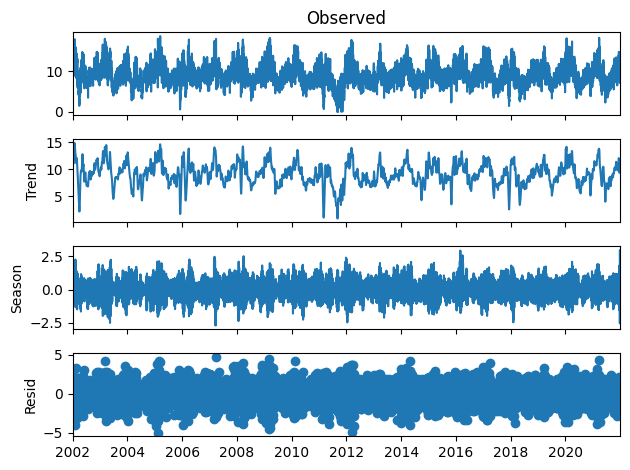

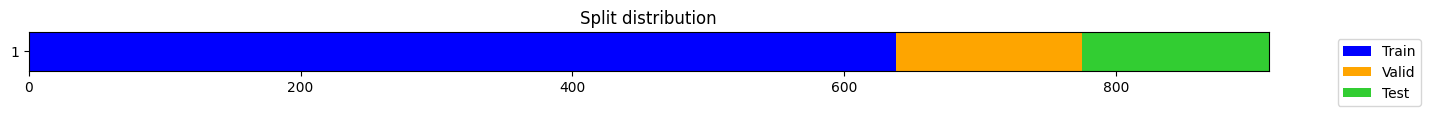

Epoch 4: reducing lr to 0.0017182018462592818
Epoch 7: reducing lr to 0.003408648040569827
Epoch 10: reducing lr to 0.004600520533369701
Epoch 13: reducing lr to 0.004770119549368837
Epoch 16: reducing lr to 0.0046263512308169115
Epoch 19: reducing lr to 0.004342264146385366
Epoch 22: reducing lr to 0.003935708613494332
Epoch 25: reducing lr to 0.003432229687452133
Epoch 28: reducing lr to 0.002863463249311685
Epoch 31: reducing lr to 0.0022651468265071644
Epoch 34: reducing lr to 0.0016748754937856076
Epoch 37: reducing lr to 0.0011297370598243477
Epoch 40: reducing lr to 0.0006639850105715411
Epoch 43: reducing lr to 0.00030688402852193096
Epoch 46: reducing lr to 8.087260170843574e-05
Epoch 49: reducing lr to 1.5154360806096668e-07
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    0.458036
valid_loss    0.505736
mae           0.883810
_rmse         1.136445
dtype: float64

RMSE: 1.329249593161397
MAE: 1.0391559986845458
R²: 0.6614652026787439
MAPE: 0.11624147150987221
Correlação Linear: 0.8218596846356147


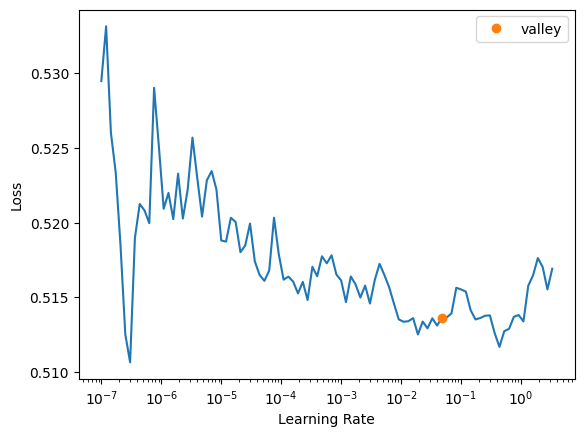

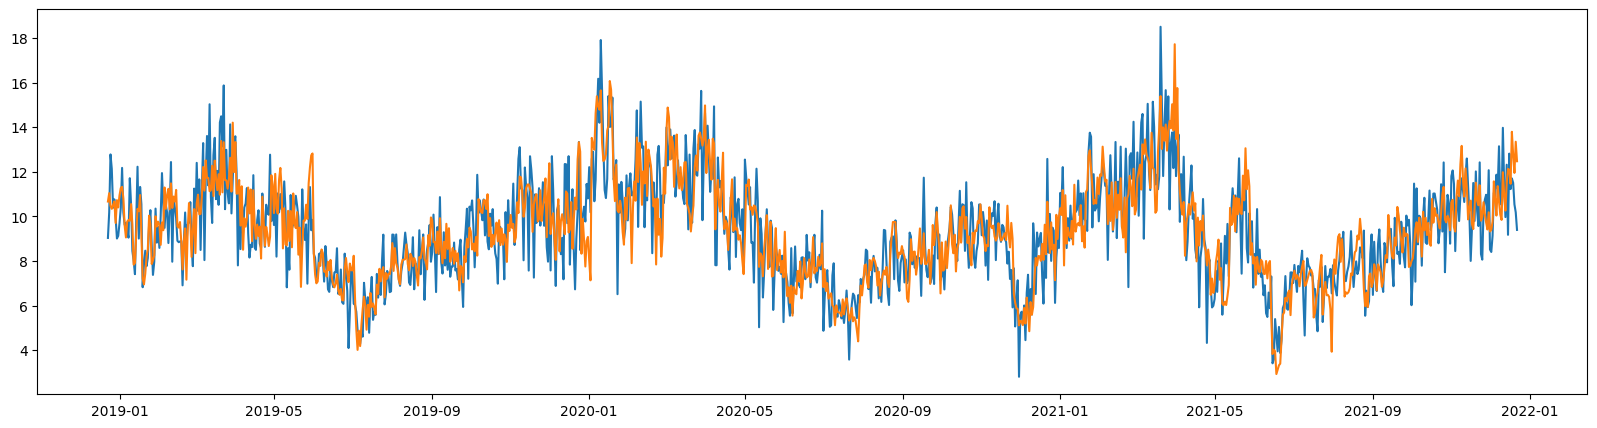

count    1096.000000
mean        0.004892
std         1.329847
min        -4.647068
25%        -0.889456
50%         0.002983
75%         0.812492
max         4.407633
dtype: float64

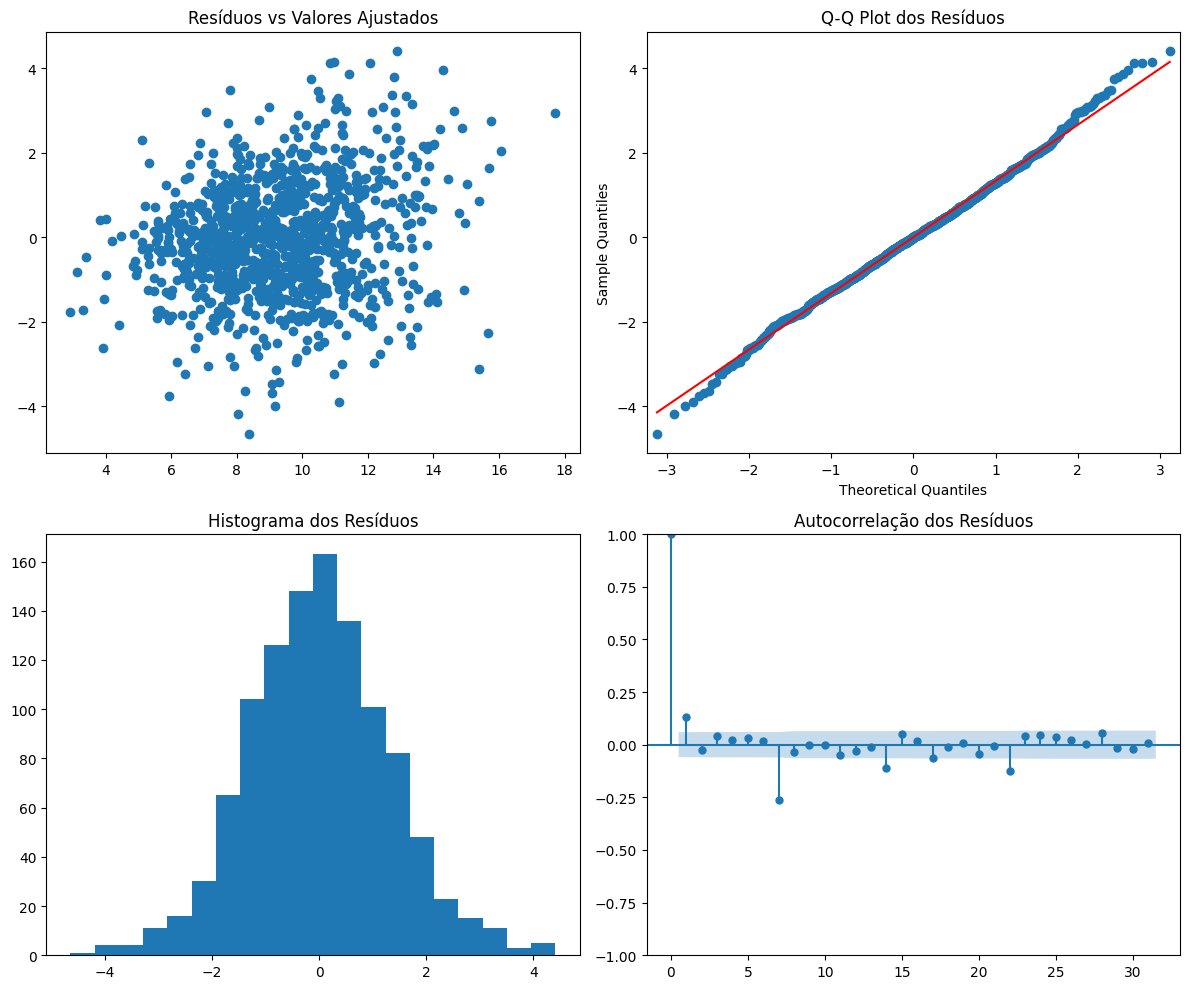

Estatística de teste: 0.9971, p-valor: 0.0406
Os resíduos não parecem seguir uma distribuição normal (rejeitamos H0)
Default LSTM


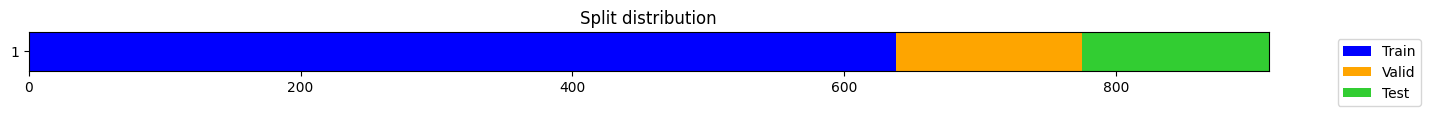

Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    1.205682
valid_loss    1.137592
mae           1.567995
_rmse         1.989492
dtype: float64

RMSE: 1.9946805238723755
MAE: 1.5430448055267334
R²: 0.3240972096514192
MAPE: 0.18537722527980804
Correlação Linear: 0.5697506443927784


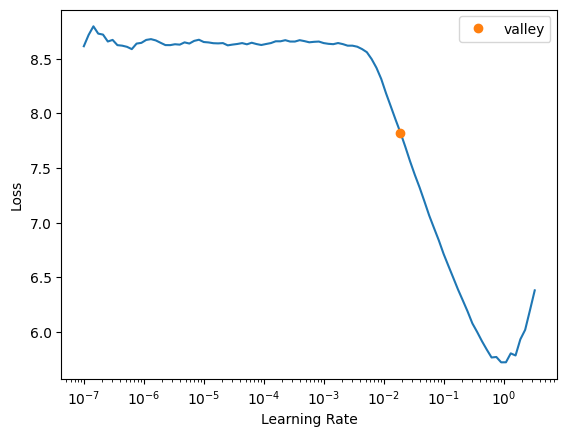

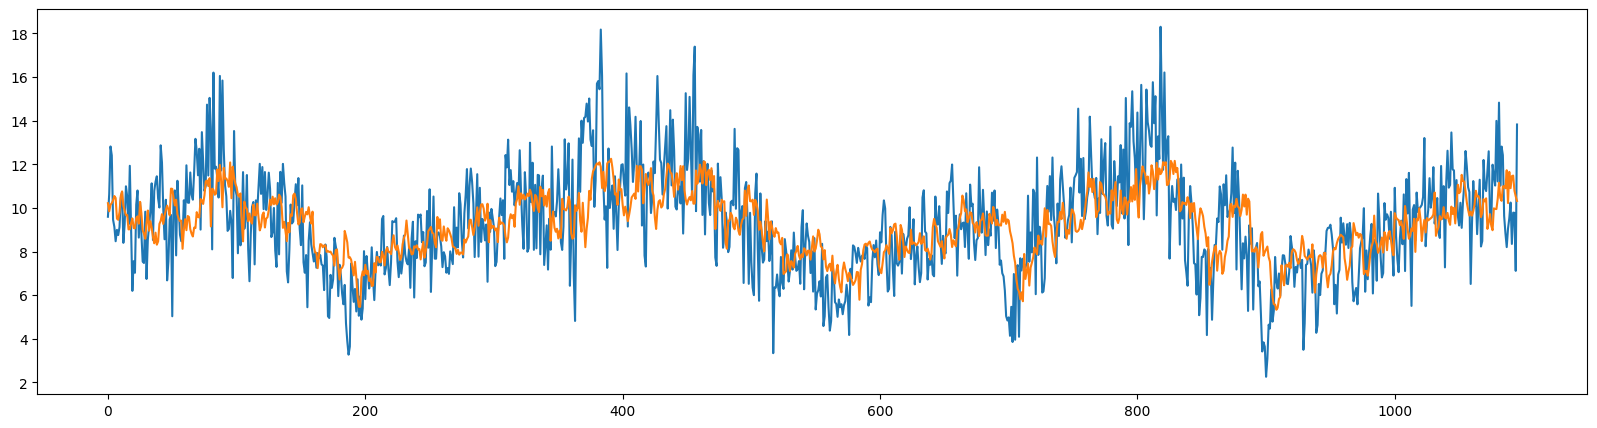

count    1096.000000
mean       -0.054913
std         1.994835
min        -7.192289
25%        -1.319963
50%         0.001656
75%         1.212743
max         5.845047
dtype: float64

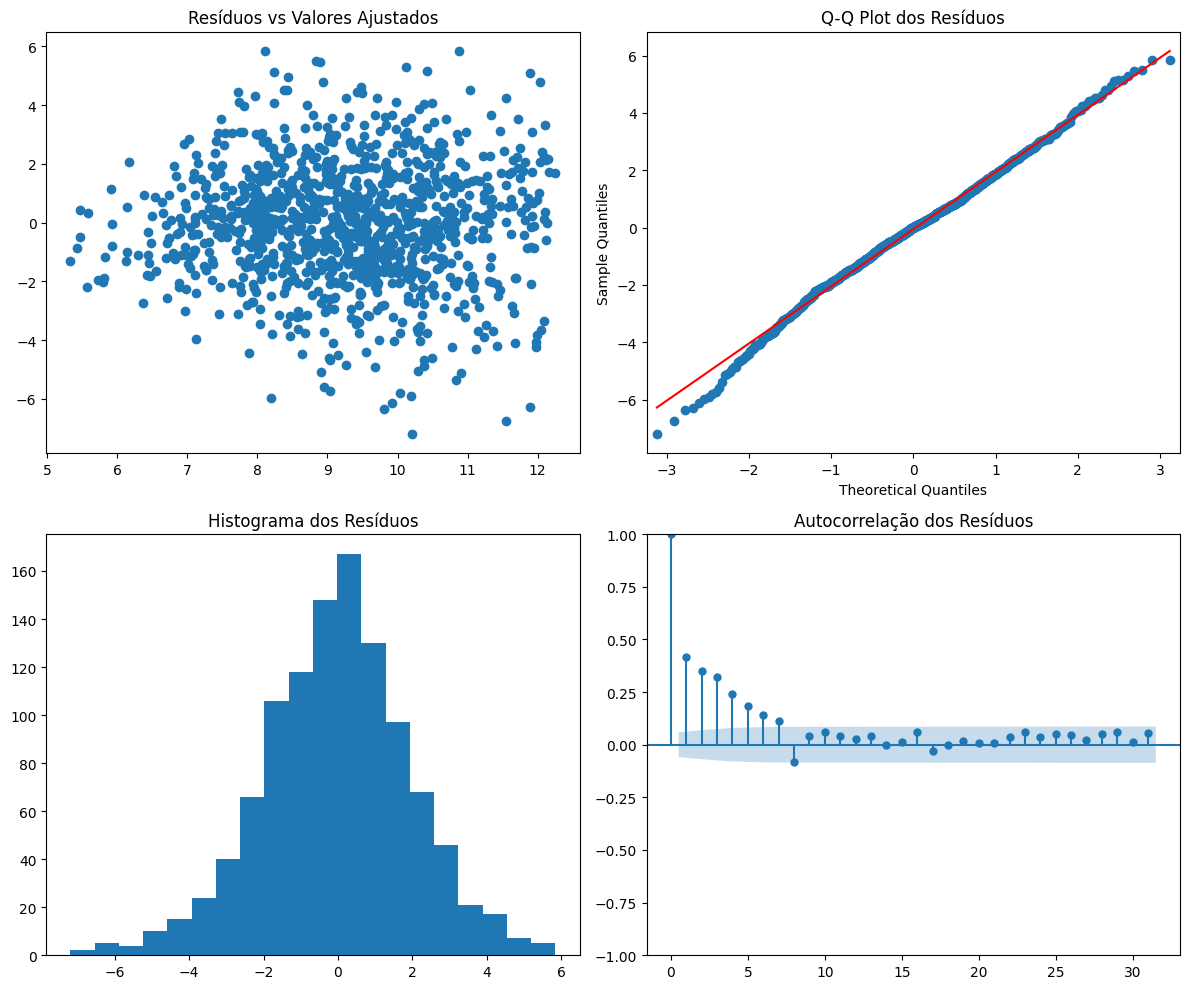

Estatística de teste: 0.9955, p-valor: 0.0028
Os resíduos não parecem seguir uma distribuição normal (rejeitamos H0)


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from tsai.all import *
from statsmodels.graphics.tsaplots import plot_acf
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *


def forecast_arima(series, new_data, seasonal=False, m=1, arima_model=None,
                    start_p=4, start_q=0, d=None, max_p=10, max_q=10, max_d=3, max_order=None,
                    start_P=1, start_Q=1, D=None, max_P=8, max_Q=8, max_D=1):
    
    if not arima_model:
        arima_model = AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d,
                                max_q=max_q, max_order=max_order, start_P=start_P, D=D, start_Q=start_Q,
                                max_P=max_P, max_D=max_D, max_Q=max_Q, seasonal=seasonal, m=m,
                                trace=False, error_action='ignore', suppress_warnings=True,
                                stepwise=True, information_criterion='aic', scoring='mse',
                                with_intercept='auto')
        
    arima_model = arima_model.fit(y=series)
    lista_previsoes = []
    for j in range(new_data.shape[0]):
        janela_8_dias = new_data[j, 0]
        previsao = arima_model.predict(n_periods=8)
        lista_previsoes.append(previsao)
        arima_model = arima_model.update(janela_8_dias)

    forecast = np.array(lista_previsoes)
    return arima_model, forecast

def forecast_exponential_smoothing(series, new_data, trend='add', seasonal='add', seasonal_periods=7,
                                    initialization_method='heuristic', use_boxcox=False):
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                    initialization_method=initialization_method, use_boxcox=use_boxcox)
    model_fit = model.fit()

    lista_previsoes = []
    for j in range(new_data.shape[0]):
        previsao = model_fit.forecast(steps=8)
        lista_previsoes.append(previsao)
        series = np.concatenate([series, new_data[j, 0]])
        model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                        initialization_method=initialization_method)
        model_fit = model.fit()

    forecast = np.array(lista_previsoes)
    return model_fit, forecast


def decompose_series(series):
    decomposed = STL(series).fit()
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    resid = decomposed.resid
    decomposed.plot()
    return trend, seasonal, resid


def load_and_prepare_data(filepath):
    peru = pd.read_csv(filepath, index_col='index').rename(columns={'GPP': 'peru'})
    peru.index = pd.to_datetime(peru.index)
    peru = peru.resample('D').mean()
    return peru


def forecast_ann(X, y, splits, model=LSTMPlus, epochs=200, arch_config={}, btfms=TSStandardize(), loss_func=nn.MSELoss(), cbs=[]):
    learn = TSForecaster(X, y, splits=splits, arch=model, metrics=[mae, rmse], arch_config=arch_config,
                         batch_tfms=btfms, tfms=[None, [TSForecasting()]], loss_func=loss_func)
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        lr = learn.lr_find()
        learn.fit_one_cycle(epochs, lr_max=lr.valley, cbs=cbs)
        print(f'Métricas de Treinamento para {model}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5]))
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]], y[splits[2]])
        return raw_preds, target


def residual_summary(forecast, target, datetime_index):
    preds_residuals = forecast - target
    residuos = pd.Series(preds_residuals, index=datetime_index.index)
    display(residuos.describe())

    valores_ajustados = forecast

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes[0, 0].scatter(valores_ajustados, preds_residuals)
    axes[0, 0].set_title('Resíduos vs Valores Ajustados')

    sm.qqplot(preds_residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot dos Resíduos')

    axes[1, 0].hist(preds_residuals, bins=20)
    axes[1, 0].set_title('Histograma dos Resíduos')

    plot_acf(preds_residuals, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelação dos Resíduos')

    plt.tight_layout()
    plt.show()

    stat, p_value = shapiro(preds_residuals)
    alpha = 0.05
    print(f'Estatística de teste: {stat:.4f}, p-valor: {p_value:.4f}')

    if p_value > alpha:
        print('Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0)')
    else:
        print('Os resíduos não parecem seguir uma distribuição normal (rejeitamos H0)')


def Default_LSTM(peru):
    peru_x,peru_y = SlidingWindow(window_len=8,horizon=8,stride=None)(peru['peru'].values)
    splits = TSSplitter(valid_size=0.15,test_size=0.15)(peru_y)
    peru_forecast, target_peru = forecast_ann(peru_x, peru_y, splits, model=LSTMPlus, epochs=100, arch_config={}, btfms=TSStandardize(), loss_func=HuberLoss('mean'))

    print(f"RMSE: {mean_squared_error(target_peru.flatten(), peru_forecast.flatten(), squared=False)}")
    print(f"MAE: {mean_absolute_error(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"R²: {r2_score(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"MAPE: {mean_absolute_percentage_error(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"Correlação Linear: {np.corrcoef(target_peru.flatten(), peru_forecast.flatten())[0, 1]}")

    plt.figure(figsize=(20, 5))
    plt.plot(target_peru.flatten())
    plt.plot(peru_forecast.flatten())
    plt.show()

    residual_summary(peru_forecast.flatten(), target_peru.flatten(), peru['peru'].loc[peru['peru'].isin(peru_y[splits[2]].flatten())])


def STL_ARIMA_ES_LSTM(peru):
    trend, seasonal, resid = decompose_series(peru)

    resid_x,resid_y = SlidingWindow(window_len=8,horizon=8,stride=None)(resid.values)
    splits_testando = TSSplitter(valid_size=0.15,test_size=0.15)(resid_y)
    residual_forecast,target_residual = forecast_ann(resid_x, resid_y,splits_testando,model=LSTMPlus, epochs=50,arch_config={},btfms=TSStandardize(),loss_func=HuberLoss('mean'),cbs=[ReduceLROnPlateau(patience=3)])

    train_values = np.concatenate([resid_x[splits_testando[0]].flatten(),resid_x[splits_testando[1]].flatten()])
    train_index = resid.loc[resid.isin(train_values)].index
    test_index = resid.loc[resid.isin(resid_x[splits_testando[2]].flatten())].index

    train_trend = trend.loc[train_index]
    test_trend = trend.loc[test_index]

    arima_model, trend_forecast = forecast_arima(series=train_trend,new_data=test_trend.values.reshape(-1,1,8))

    train_seasonal = seasonal.loc[train_index]
    test_seasonal = seasonal.loc[test_index]
    es_model, seasonal_forecast = forecast_exponential_smoothing(series=train_seasonal,new_data=test_seasonal.values.reshape(-1,1,8),trend=None,seasonal_periods=7)

    final_pred = residual_forecast.flatten() + seasonal_forecast.flatten() + trend_forecast.flatten()
    real_values = target_residual.numpy().flatten() + test_trend + seasonal[test_trend.index]
    final_pred = final_pred.numpy()

    print(f"RMSE: {mean_squared_error(real_values, final_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(real_values, final_pred)}")
    print(f"R²: {r2_score(real_values, final_pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(real_values, final_pred)}")
    print(f"Correlação Linear: {np.corrcoef(real_values, final_pred)[0, 1]}")

    plt.figure(figsize=(20, 5))
    plt.plot(real_values.index, real_values)
    plt.plot(real_values.index, final_pred)
    plt.show()

    residual_summary(final_pred, real_values, resid.loc[resid.isin(resid_x[splits_testando[2]].flatten())])


def main():
    filepath = 'peru.csv'
    peru = load_and_prepare_data(filepath)
    print('====================================================================================================')
    print('STL + ARIMA + ES + LSTM')
    STL_ARIMA_ES_LSTM(peru=peru)
    print('====================================================================================================')
    print('Default LSTM')
    Default_LSTM(peru=peru)


if __name__ == '__main__':
    main()